# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "vendorProject" : "Vendor", "product" : "Product"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


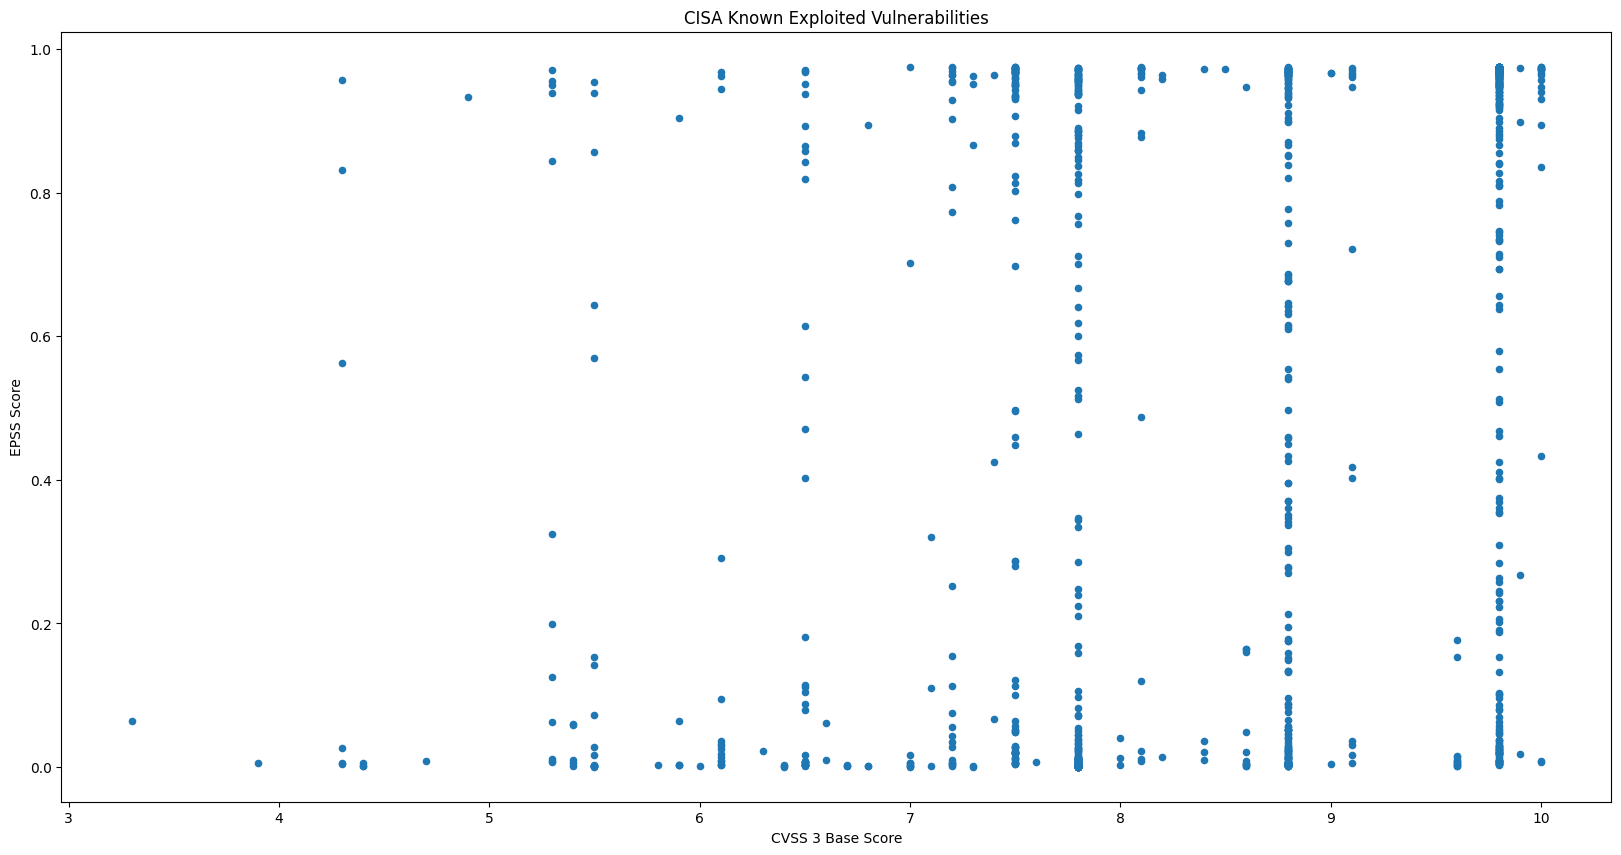

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CVS

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2024-12356,NaN,0.00235,0.61114,BeyondTrust Privileged Remote Access (PRA) and...,BeyondTrust,Privileged Remote Access (PRA) and Remote Supp...
1,CVE-2021-40407,9.8,0.03083,0.90813,Reolink RLC-410W IP cameras contain an authent...,Reolink,RLC-410W IP Camera
2,CVE-2019-11001,7.2,0.15507,0.95870,"Reolink RLC-410W, C1 Pro, C2 Pro, RLC-422W, an...",Reolink,Multiple IP Cameras
3,CVE-2022-23227,9.8,0.26293,0.96740,NUUO NVRmini 2 devices contain a missing authe...,NUUO,NVRmini2 Devices
4,CVE-2018-14933,9.8,0.93597,0.99320,NUUO NVRmini devices contain an OS command inj...,NUUO,NVRmini Devices
5,CVE-2024-55956,NaN,0.01179,0.84784,"Cleo Harmony, VLTrader, and LexiCom, which are...",Cleo,Multiple Products
6,CVE-2024-35250,7.8,0.00126,0.47798,Microsoft Windows Kernel-Mode Driver contains ...,Microsoft,Windows
7,CVE-2024-20767,7.4,0.96394,0.99705,Adobe ColdFusion contains an improper access c...,Adobe,ColdFusion
8,CVE-2024-50623,NaN,0.09824,0.94841,"Cleo Harmony, VLTrader, and LexiCom, which are...",Cleo,Multiple Products
9,CVE-2024-49138,NaN,0.00043,0.10989,Microsoft Windows Common Log File System (CLFS...,Microsoft,Windows
